In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from imblearn.over_sampling import SMOTE

In [229]:
df=pd.read_csv('seattle-weather.csv')

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [231]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [232]:
df['weather'].value_counts()

weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64

In [233]:
df['date']=pd.to_datetime(df['date'])
df.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [234]:
le=LabelEncoder()
df['weather']=le.fit_transform(df['weather'])

In [235]:
features=df[['precipitation','temp_max','temp_min','wind']].values
labels=df['weather'].values

In [236]:
scaler=StandardScaler()
features_scaler=scaler.fit_transform(features)

In [237]:
X_train, X_test,y_train,y_test =train_test_split(features_scaler,labels,test_size=0.2,random_state=42)
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# One-hot cho output
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [238]:
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=64, dropout=0.1):
    # Chiếu inputs (3) lên đúng key_dim=64
    x_proj = layers.Dense(head_size)(inputs)  # shape: (None, 1, 64)

    # Multi-head attention
    x = layers.LayerNormalization(epsilon=1e-6)(x_proj)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    x = x + x_proj  # Residual (cùng shape: (None, 1, 64))

    # Feed-forward block
    x_ffn = layers.LayerNormalization(epsilon=1e-6)(x)
    x_ffn = layers.Dense(ff_dim, activation="relu")(x_ffn)
    x_ffn = layers.Dropout(dropout)(x_ffn)
    return x + x_ffn  # Residual


# Xây dựng mô hình
input_layer = layers.Input(shape=(1, 4))
x = transformer_encoder(input_layer)
x = layers.GlobalAveragePooling1D()(x)
embedding_model = models.Model(inputs=input_layer, outputs=x)
embedding_model.save("transformer_embedding_model.h5")
X_train_embed = embedding_model.predict(X_train, verbose=0)
X_test_embed = embedding_model.predict(X_test, verbose=0)


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [239]:
class SimpleGaussianNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes)

        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0) + 1e-9
            self.priors[idx] = X_c.shape[0] / X.shape[0]

    def log_gaussian_pdf(self, x, mean, var):
        return -0.5 * np.log(2 * np.pi * var) - ((x - mean) ** 2) / (2 * var)

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for idx, c in enumerate(self.classes):
                prior = np.log(self.priors[idx])
                conditional = np.sum(self.log_gaussian_pdf(x, self.mean[idx], self.var[idx]))
                posterior = prior + conditional
                posteriors.append(posterior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)


In [240]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Đánh giá kết quả
print("Đánh giá mô hình Gaussian Naive Bayes (sau Transformer):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Đánh giá mô hình Gaussian Naive Bayes (sau Transformer):
Accuracy: 0.590443686006826
Classification Report:
              precision    recall  f1-score   support

     drizzle       0.16      0.33      0.21         9
         fog       0.27      0.36      0.31        25
        rain       0.85      0.57      0.69       120
        snow       0.14      0.88      0.24         8
         sun       0.77      0.65      0.71       131

    accuracy                           0.59       293
   macro avg       0.44      0.56      0.43       293
weighted avg       0.73      0.59      0.64       293

Confusion Matrix:
[[ 3  2  0  1  3]
 [ 7  9  0  3  6]
 [ 1  8 69 26 16]
 [ 0  0  1  7  0]
 [ 8 14 11 13 85]]


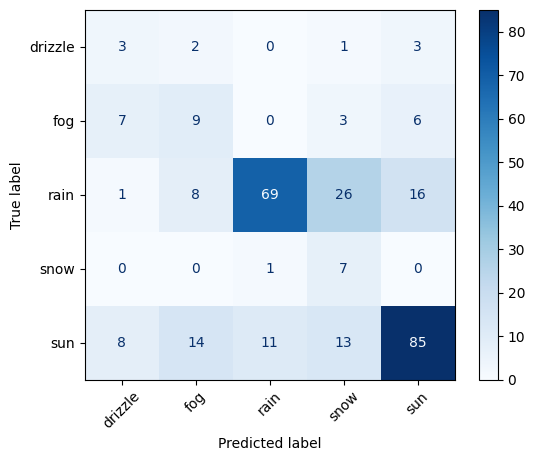

In [241]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Giả sử bạn đã có y_true và y_pred
# Nhãn cũ (tên lớp)
labels = ['drizzle', 'fog', 'rain', 'snow', 'sun']

# Tạo confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Hiển thị confusion matrix với tên lớp
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)